# PMEL ERDDAP M2 Data Visualization - Example of Using Python+ERDDAP

__pyversion__==3.8   
__author__==S.Bell

In [1]:
import datetime
print("Last run {0}".format(datetime.datetime.now()))

Last run 2021-01-21 16:56:20.007798


erddapy is the python erddap library - https://ioos.github.io/erddapy - it essentially builds the RESTful url for datasets and has a convenience tool for downloading csv or ncCF data to be manipulated in pandas or xarray

pandas, numpy,cmocean (for color pallettes) and matplotlib are other libraries you will likely need to have installed, as well as xarray and netCDF4 if you choose to visualize the data that way (xarray is good for gridded data, pandas is good for tabular data)

## Initializing python

In [2]:
from erddapy import ERDDAP
import pandas as pd
import numpy as np

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cmocean


## Connecting and Searching ERDDAP datasets

In [3]:
server_url='http://akutan.pmel.noaa.gov:8080/erddap/'
e = ERDDAP(server=server_url)

# search the chosen server for 'EcoFOCI', return the results as csv data and read into a pandas dataframe
url = e.get_search_url(response='csv', search_for='EcoFOCI')
df = pd.read_csv(url)

# note, the dataframe above actually holds all the content shown in the yellow table on the subsequent html page - https://ferret.pmel.noaa.gov/pmel/erddap/search/index.html?page=1&itemsPerPage=1000&searchFor=ecofoci
# but I only want to know the Dataset ID as it is the unique identifier for each dataset and the way to begin building the url or opendap endpoint
print(df['Dataset ID'].values)

['EcoFOCI_Bering_Sea_timeseries_data' 'foci_rehosted_e932_978b_9e7c'
 'ChukchiSea_454a_037a_fcf4' 'arcticRescueData_e5bf_cef8_3f72'
 'Shelikof_line8_3695_0ada_d066' 'dy1104_profile_data'
 'dy1408_profile_data' 'mf0904_profile_data'
 '2019_PopUP_300434063823800_irridium_position'
 '2019_PopUP_300434063921240_irridium_position'
 '2019_PopUP_300434063925210_irridium_position'
 '2019_PopUP_300434063928220_irridium_position' 'CTD_dy1704_final_oxy'
 'ADCP_Mooring_10ckp2a_final' 'ADCP_Mooring_11ckp2a_final'
 'ADCP_Mooring_13ckp7a_final' 'ADCP_Mooring_14bsp2a_final'
 'ADCP_Mooring_14bsp5a_final' 'ADCP_Mooring_14bsp8a_final'
 'ADCP_Mooring_14ckp1a_final' 'ADCP_Mooring_14ckp4a_final'
 'ADCP_Mooring_14ckp5a_final' 'ADCP_Mooring_14ckp6a_final'
 'ADCP_Mooring_14ckp8a_final' 'ADCP_Mooring_15bsp4a_final'
 'ADCP_Mooring_15ckp1a_final' 'ADCP_Mooring_15ckp2a_final'
 'ADCP_Mooring_16bsp2a_final' 'ADCP_Mooring_16bsp2b_final'
 'ADCP_Mooring_16bsp5a_final' 'ADCP_Mooring_16bsp8a_final'
 'ADCP_Mooring_16ckp2a

All the above listed datasets meet the qualification of having EcoFOCI in their metadata

In [4]:
# summarize the dataset types

df = pd.read_csv(url)
print(
    f'We have {len(set(df["tabledap"].dropna()))} '
    f'tabledap, {len(set(df["griddap"].dropna()))} '
    f'griddap, and {len(set(df["wms"].dropna()))} wms endpoints.'
)

We have 485 tabledap, 515 griddap, and 0 wms endpoints.


Choose just one of relevance... its a collection of timeseries data (different depths, years, instruments and parameters)

In [5]:
dataset_id = 'foci_rehosted_e932_978b_9e7c'

## retrieving and plotting data

In [6]:
#convenience dictionary to put user specified parameters
kw = {
    'min_lon': -180.0,
    'max_lon': -130.0,
    'min_lat': 55.0,
    'max_lat': 90.0,
    'min_time': '2010-01-10T00:00:00Z',
    'max_time': '2019-01-10T00:00:00Z',
}

#setting constraints on dataset to only get data you are interested, this can be spatial or temporal constraints
#it can also be keyword constraints or variable constraints

constraints = {
    'longitude>=': kw['min_lon'],
    'longitude<=': kw['max_lon'],
    'latitude>=': kw['min_lat'],
    'latitude<=': kw['max_lat'],
    'time>=': kw['min_time'],
    'time<=': kw['max_time'],
}

#the following line defines all variables of interest by dumping all the variables, then dropping 'NC_GLOBAL'
#its a hack because clearly I don't understand what I'm doing exactly
variables =  e.get_var_by_attr(dataset_id=dataset_id, variable=lambda v: v != 'emptyplaceholder')
while 'NC_GLOBAL' in variables: variables.remove('NC_GLOBAL')

# alternatively you could just create a list of variables or subset of variables as follows:
# variables = ['longitude','id','latitude','ocean_temperature_1','lon360','depth','time']

## generate a url to the "htmlTable" form of the result (clickable)

In [7]:
# - the following will generate a shareable url - you can even cut and past it into your browser to see the "results" as a html table
download_url = e.get_download_url(
    dataset_id=dataset_id,
    protocol='tabledap',
    response='htmlTable',
    variables=variables,
)

print(download_url)

http://akutan.pmel.noaa.gov:8080/erddap/tabledap/foci_rehosted_e932_978b_9e7c.htmlTable?longitude,ocean_chlorophyll_fluorescence_raw_standard_deviation,photosynthetically_active_radiation,depth,ocean_current_direction_component_true_north,ocean_dissolved_oxygen_concentration_1_mMperkg,ocean_current_speed_component,id,ocean_temperature_1,ocean_chlorophyll_a_concentration_factoryCal,ocean_depth,ocean_velocity_u_eastward_true_north,lon360,ocean_oxygen_saturation_1,ocean_velocity_v_northward_true_north,ocean_chlorophyll_fluorescence_raw,ocean_practical_salinity_1,ocean_turbidity_FNU,latitude,ocean_conductivity_1,time,photosynthetically_active_radiation_raw


## User erddapy convenience function to load content from search above into pandas data frame for plotting and manipulation

if you just retain all variables, this can be a fairly large download... although it is "compressed" if retrieved via the web as a csv file, it is not clear if it is compressed in the convenience function used here

In [8]:
from requests.exceptions import HTTPError

try:
    e = ERDDAP(server=server_url,
        protocol='tabledap',
        response='csv'
    )
    e.variables=variables
    e.dataset_id=dataset_id
except HTTPError:
    print('Failed to generate url {}'.format(dataset_id))

try:
    df = e.to_pandas(
                        index_col='time (UTC)', #index based on time - useful for applying pandas temporal filters
                        parse_dates=True,
                        skiprows=(1,)  # units information can be dropped.
                        )
    df.columns = [x[1].split()[0] for x in enumerate(df.columns)] #simplifies variable names... removes units
except:
    pass

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1956198 entries, 2010-10-05 04:00:00+00:00 to 2017-04-16 11:00:00+00:00
Data columns (total 21 columns):
 #   Column                                                 Dtype  
---  ------                                                 -----  
 0   longitude                                              float64
 1   ocean_chlorophyll_fluorescence_raw_standard_deviation  float64
 2   photosynthetically_active_radiation                    float64
 3   depth                                                  float64
 4   ocean_current_direction_component_true_north           float64
 5   ocean_dissolved_oxygen_concentration_1_mMperkg         float64
 6   ocean_current_speed_component                          float64
 7   id                                                     object 
 8   ocean_temperature_1                                    float64
 9   ocean_chlorophyll_a_concentration_factoryCal           float64
 10  ocean_depth          

In [10]:
#this is just a random sample of 10 rows within the dataset
df.sample(10)

,longitude,ocean_chlorophyll_fluorescence_raw_standard_deviation,photosynthetically_active_radiation,depth,ocean_current_direction_component_true_north,ocean_dissolved_oxygen_concentration_1_mMperkg,ocean_current_speed_component,id,ocean_temperature_1,ocean_chlorophyll_a_concentration_factoryCal,...,ocean_velocity_u_eastward_true_north,lon360,ocean_oxygen_saturation_1,ocean_velocity_v_northward_true_north,ocean_chlorophyll_fluorescence_raw,ocean_practical_salinity_1,ocean_turbidity_FNU,latitude,ocean_conductivity_1,photosynthetically_active_radiation_raw
time (UTC),,,,,,,,,,,,,,,,,,,,,
2016-01-18 10:00:00+00:00,-164.0663,7.434241,NaN,11.0,NaN,NaN,NaN,15bs2c_ecf_0011m,NaN,0.382901,...,92.743340,195.9337,NaN,NaN,NaN,NaN,NaN,56.870617,NaN,NaN
2011-02-19 20:40:00+00:00,-164.0622,NaN,NaN,33.0,NaN,NaN,NaN,10bs2c_s39_0033m,-0.857398,NaN,...,NaN,195.9378,NaN,NaN,NaN,NaN,NaN,56.864100,NaN,NaN
2010-12-22 00:00:00+00:00,-164.0622,NaN,NaN,21.0,NaN,NaN,NaN,10bs2c_s39_0021m,0.620000,NaN,...,NaN,195.9378,NaN,NaN,NaN,NaN,NaN,56.864100,NaN,NaN
2015-11-18 18:50:00+00:00,-164.0663,NaN,NaN,40.0,NaN,NaN,NaN,15bs2c_mt4008_0040m,5.311899,NaN,...,NaN,195.9337,NaN,NaN,NaN,NaN,NaN,56.870617,NaN,NaN
2014-10-29 21:50:00+00:00,-164.0630,NaN,NaN,50.0,NaN,NaN,NaN,14bs2c_mt3267_0050m,5.218250,NaN,...,NaN,195.9370,NaN,NaN,NaN,NaN,NaN,56.869118,NaN,NaN
2011-10-06 00:30:00+00:00,-164.0516,NaN,NaN,23.0,NaN,NaN,NaN,11bs2c_s39_0023m,7.084010,NaN,...,NaN,195.9484,NaN,NaN,NaN,NaN,NaN,56.863300,NaN,NaN
2015-11-06 02:10:00+00:00,-164.0663,NaN,NaN,40.0,NaN,NaN,NaN,15bs2c_mt4016_0040m,6.922808,NaN,...,NaN,195.9337,NaN,NaN,NaN,NaN,NaN,56.870617,NaN,NaN
2012-09-14 14:00:00+00:00,-164.0560,NaN,NaN,15.0,30.278564,278.4658,16.098293,12bs2c_an9_0015m,6.536436,NaN,...,8.116836,195.9440,91.35773,13.90223,NaN,31.2823,0.583869,56.868000,31.50576,NaN
2011-12-19 00:50:00+00:00,-164.0516,NaN,NaN,60.0,NaN,NaN,NaN,11bs2c_mt_0060m,3.244262,NaN,...,NaN,195.9484,NaN,NaN,NaN,NaN,NaN,56.863300,NaN,NaN


### WARNING - An Aside to the tabular data and multiple datastreams

Be aware that the way the tabular data is retained is not monotonic (even though its indexed on time, there may be multiple equivalent time entries for different instruments) Each data point from an instrument is recorded as a row with all relevant data included and each column is a measurement type... if the instrument doesn't measure a parameter.. than it will be missing).  You may think all measurements at the same time would result in a single row with multiple values but that would require many columns to represent each potential value+instrument/platform

An example follows: look at one moment in time and notice there are 10 entries... each for a different id at a different depth.  This is where the pandas "groupby" function/accessor will come in handy

In [11]:
df.loc['2012-03-24 03:20:00']

,longitude,ocean_chlorophyll_fluorescence_raw_standard_deviation,photosynthetically_active_radiation,depth,ocean_current_direction_component_true_north,ocean_dissolved_oxygen_concentration_1_mMperkg,ocean_current_speed_component,id,ocean_temperature_1,ocean_chlorophyll_a_concentration_factoryCal,...,ocean_velocity_u_eastward_true_north,lon360,ocean_oxygen_saturation_1,ocean_velocity_v_northward_true_north,ocean_chlorophyll_fluorescence_raw,ocean_practical_salinity_1,ocean_turbidity_FNU,latitude,ocean_conductivity_1,photosynthetically_active_radiation_raw
time (UTC),,,,,,,,,,,,,,,,,,,,,
2012-03-24 03:20:00+00:00,-164.0516,NaN,NaN,45.0,NaN,NaN,NaN,11bs2c_mt_0045m,-1.588048,NaN,...,NaN,195.9484,NaN,NaN,NaN,NaN,NaN,56.8633,NaN,NaN
2012-03-24 03:20:00+00:00,-164.0516,NaN,NaN,45.0,NaN,NaN,NaN,11bs2c_mt_0046m,-1.585855,NaN,...,NaN,195.9484,NaN,NaN,NaN,NaN,NaN,56.8633,NaN,NaN
2012-03-24 03:20:00+00:00,-164.0516,NaN,NaN,60.0,NaN,NaN,NaN,11bs2c_mt_0060m,-1.146838,NaN,...,NaN,195.9484,NaN,NaN,NaN,NaN,NaN,56.8633,NaN,NaN
2012-03-24 03:20:00+00:00,-164.0516,NaN,NaN,60.0,NaN,NaN,NaN,11bs2c_mt_0061m,-1.159999,NaN,...,NaN,195.9484,NaN,NaN,NaN,NaN,NaN,56.8633,NaN,NaN
2012-03-24 03:20:00+00:00,-164.0516,NaN,NaN,20.0,NaN,NaN,NaN,11bs2c_s39_0020m,-1.662700,NaN,...,NaN,195.9484,NaN,NaN,NaN,NaN,NaN,56.8633,NaN,NaN
2012-03-24 03:20:00+00:00,-164.0516,NaN,NaN,23.0,NaN,NaN,NaN,11bs2c_s39_0023m,-1.662800,NaN,...,NaN,195.9484,NaN,NaN,NaN,NaN,NaN,56.8633,NaN,NaN
2012-03-24 03:20:00+00:00,-164.0516,NaN,NaN,27.0,NaN,NaN,NaN,11bs2c_s39_0027m,-1.574400,NaN,...,NaN,195.9484,NaN,NaN,NaN,NaN,NaN,56.8633,NaN,NaN
2012-03-24 03:20:00+00:00,-164.0516,NaN,NaN,35.0,NaN,NaN,NaN,11bs2c_s39_0035m,-1.579600,NaN,...,NaN,195.9484,NaN,NaN,NaN,NaN,NaN,56.8633,NaN,NaN
2012-03-24 03:20:00+00:00,-164.0516,NaN,NaN,40.0,NaN,NaN,NaN,11bs2c_s39_0040m,-1.588400,NaN,...,NaN,195.9484,NaN,NaN,NaN,NaN,NaN,56.8633,NaN,NaN


### Groupby example

lets just group on the instrument '11bs2c_s39_0050m' (an sbe 39 on the 2011 BS2C mooring at 50m depth)

In [12]:
df.groupby(df['id']).get_group('11bs2c_s39_0050m')

,longitude,ocean_chlorophyll_fluorescence_raw_standard_deviation,photosynthetically_active_radiation,depth,ocean_current_direction_component_true_north,ocean_dissolved_oxygen_concentration_1_mMperkg,ocean_current_speed_component,id,ocean_temperature_1,ocean_chlorophyll_a_concentration_factoryCal,...,ocean_velocity_u_eastward_true_north,lon360,ocean_oxygen_saturation_1,ocean_velocity_v_northward_true_north,ocean_chlorophyll_fluorescence_raw,ocean_practical_salinity_1,ocean_turbidity_FNU,latitude,ocean_conductivity_1,photosynthetically_active_radiation_raw
time (UTC),,,,,,,,,,,,,,,,,,,,,
2011-09-27 03:00:00+00:00,-164.0516,NaN,NaN,50.0,NaN,NaN,NaN,11bs2c_s39_0050m,3.068100,NaN,...,NaN,195.9484,NaN,NaN,NaN,NaN,NaN,56.8633,NaN,NaN
2011-09-27 03:10:00+00:00,-164.0516,NaN,NaN,50.0,NaN,NaN,NaN,11bs2c_s39_0050m,3.067000,NaN,...,NaN,195.9484,NaN,NaN,NaN,NaN,NaN,56.8633,NaN,NaN
2011-09-27 03:20:00+00:00,-164.0516,NaN,NaN,50.0,NaN,NaN,NaN,11bs2c_s39_0050m,3.069500,NaN,...,NaN,195.9484,NaN,NaN,NaN,NaN,NaN,56.8633,NaN,NaN
2011-09-27 03:30:00+00:00,-164.0516,NaN,NaN,50.0,NaN,NaN,NaN,11bs2c_s39_0050m,3.068068,NaN,...,NaN,195.9484,NaN,NaN,NaN,NaN,NaN,56.8633,NaN,NaN
2011-09-27 03:40:00+00:00,-164.0516,NaN,NaN,50.0,NaN,NaN,NaN,11bs2c_s39_0050m,3.069700,NaN,...,NaN,195.9484,NaN,NaN,NaN,NaN,NaN,56.8633,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-05-08 16:20:00+00:00,-164.0516,NaN,NaN,50.0,NaN,NaN,NaN,11bs2c_s39_0050m,-0.662300,NaN,...,NaN,195.9484,NaN,NaN,NaN,NaN,NaN,56.8633,NaN,NaN
2012-05-08 16:30:00+00:00,-164.0516,NaN,NaN,50.0,NaN,NaN,NaN,11bs2c_s39_0050m,-0.668200,NaN,...,NaN,195.9484,NaN,NaN,NaN,NaN,NaN,56.8633,NaN,NaN
2012-05-08 16:40:00+00:00,-164.0516,NaN,NaN,50.0,NaN,NaN,NaN,11bs2c_s39_0050m,-0.678600,NaN,...,NaN,195.9484,NaN,NaN,NaN,NaN,NaN,56.8633,NaN,NaN


### Plotting (finally)

Text(0.5, 0, 'foci_rehosted_e932_978b_9e7c')

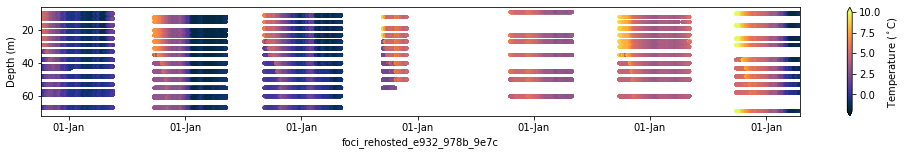

In [13]:
# here we will plot every time (index) against every depth and colorcode it as a function of temperature... nan's will be unplotted
fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(df.index, df['depth'], s=15, c=df['ocean_temperature_1'], marker='o', edgecolor='none', vmin=-2, vmax=10, cmap=cmocean.cm.thermal)

ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%d-%b')
ax.xaxis.set_major_formatter(xfmt)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Temperature ($^\circ$C)')
ax.set_ylabel('Depth (m)')
ax.set_xlabel(dataset_id)
#fig.savefig(dataset_id+'.png',dpi=300)

Text(0.5, 0, 'foci_rehosted_e932_978b_9e7c')

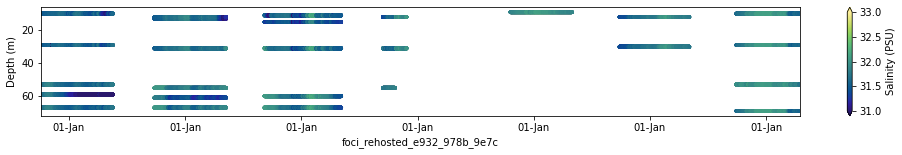

In [14]:
# here we will plot every time (index) against every depth and colorcode it as a function of salinity... nan's will be unplotted

fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(df.index, df['depth'], s=15, c=df['ocean_practical_salinity_1'], marker='o', edgecolor='none', vmin=31, vmax=33, cmap=cmocean.cm.haline)

ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%d-%b')
ax.xaxis.set_major_formatter(xfmt)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Salinity (PSU)')
ax.set_ylabel('Depth (m)')
ax.set_xlabel(dataset_id)

Text(0.5, 0, 'foci_rehosted_e932_978b_9e7c')

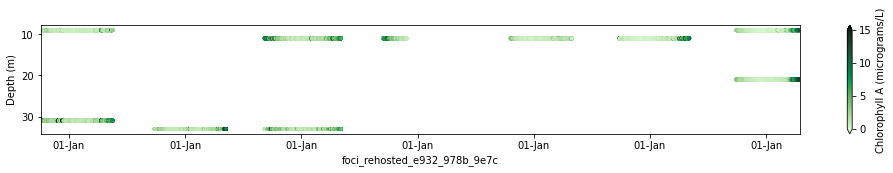

In [15]:
# here we will plot every time (index) against every depth and colorcode it as a function of chlorphyll... nan's will be unplotted
fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(df.index, df['depth'], s=15, c=df['ocean_chlorophyll_a_concentration_factoryCal'], marker='o', edgecolor='none', vmin=0, vmax=15, cmap=cmocean.cm.algae)

ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%d-%b')
ax.xaxis.set_major_formatter(xfmt)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Chlorophyll A (micrograms/L)')
ax.set_ylabel('Depth (m)')
ax.set_xlabel(dataset_id)

## ERDDAPY's .ncCF/xarray convenience function (so almost sorta, kinda like you would expect opendap to give)

In [16]:
import xarray as xa

In [17]:
#using all the same settings as above

e = ERDDAP(server=server_url,
    protocol='tabledap',
    response='nc'
)
e.variables=variables
e.dataset_id=dataset_id

xnc = e.to_ncCF() #for quasi direct netcdf exploration
xdf = e.to_xarray() #for use in xarray <- used furthur in this demo


In [18]:
xdf

<xarray.Dataset>
Dimensions:                                                (obs: 1956199, timeseries: 103)
Coordinates:
    longitude                                              (timeseries) float32 ...
    depth                                                  (timeseries) float32 ...
    latitude                                               (timeseries) float32 ...
    time                                                   (obs) datetime64[ns] ...
Dimensions without coordinates: obs, timeseries
Data variables:
    id                                                     (timeseries) object ...
    lon360                                                 (timeseries) float32 ...
    rowSize                                                (timeseries) int32 ...
    ocean_chlorophyll_fluorescence_raw_standard_deviation  (obs) float32 ...
    photosynthetically_active_radiation                    (obs) float32 ...
    ocean_current_direction_component_true_north           (obs) float32 ...
    ocean_dissolved_oxygen_concentration_1_mMperkg         (obs) float32 ...
    ocean_current_speed_component                          (obs) float32 ...
    ocean_temperature_1                                    (obs) float32 ...
    ocean_chlorophyll_a_concentration_factoryCal           (obs) float32 ...
    ocean_depth                                            (obs) float32 ...
    ocean_velocity_u_eastward_true_north                   (obs) float32 ...
    ocean_oxygen_saturation_1                              (obs) float32 ...
    ocean_velocity_v_northward_true_north                  (obs) float32 ...
    ocean_chlorophyll_fluorescence_raw                     (obs) float32 ...
    ocean_practical_salinity_1                             (obs) float32 ...
    ocean_turbidity_FNU                                    (obs) float32 ...
    ocean_conductivity_1                                   (obs) float32 ...
    photosynthetically_active_radiation_raw                (obs) float32 ...
Attributes:
    cdm_data_type:                 TimeSeries
    cdm_timeseries_variables:      id, longitude, lon360, latitude, depth
    Conventions:                   CF-1.6, COARDS, ACDD-1.3
    creator_name:                  PMEL EcoFOCI
    creator_type:                  institution
    Easternmost_Easting:           -164.0506
    featureType:                   TimeSeries
    geospatial_lat_max:            56.8796
    geospatial_lat_min:            56.8633
    geospatial_lat_units:          degrees_north
    geospatial_lon_max:            -164.0506
    geospatial_lon_min:            -164.0663
    geospatial_lon_units:          degrees_east
    geospatial_vertical_max:       69.0
    geospatial_vertical_min:       9.0
    geospatial_vertical_positive:  down
    geospatial_vertical_units:     m
    history:                       FERRET V7.42 (optimized) 27-Aug-18FERRET V...
    id:                            EcoFOCI_Bering_Sea_timeseries_data_8571_f3...
    infoUrl:                       ???
    institution:                   PMEL EcoFOCI
    keywords:                      2010-2017, active, bering, calibration, ch...
    keywords_vocabulary:           GCMD Science Keywords
    license:                       The data may be used and redistributed for...
    Northernmost_Northing:         56.8796
    sourceUrl:                     (local files)
    Southernmost_Northing:         56.8633
    standard_name_vocabulary:      CF Standard Name Table v29
    subsetVariables:               id, longitude, lon360, latitude, depth
    summary:                       Pacific Marine Environmental Laboratory (P...
    time_coverage_end:             2017-04-16T11:20:00Z
    time_coverage_start:           2010-10-05T03:00:00Z
    title:                         PMEL EcoFOCI Bering Sea, 2010-2017
    Westernmost_Easting:           -164.0663

**notice that xarray sees this as a collection of 103 different timeseries with a total of 1956199 total observations**

question is - does this data set load entirely? or is it lazily loaded (an issue for large datasets - and clearly a place where opendap is superior... since it can inspect the metadata without transferring the whole file)... my guess is that it is not lazy

xarray then provides ways to slice, splice and manipulate this data

rowSize will be your additional key for splicing data

In [19]:
#get all timeseries ids
xdf=xdf.swap_dims({"obs": "time"})
xdf=xdf.swap_dims({"timeseries": "id"})
xdf

<xarray.Dataset>
Dimensions:                                                (id: 103, time: 1956199)
Coordinates:
    longitude                                              (id) float32 -164....
    depth                                                  (id) float32 13.0 ...
  * id                                                     (id) object '10bs2...
    latitude                                               (id) float32 56.86...
  * time                                                   (time) datetime64[ns] ...
Data variables:
    lon360                                                 (id) float32 195.9...
    rowSize                                                (id) int32 10848 ....
    ocean_chlorophyll_fluorescence_raw_standard_deviation  (time) float32 ...
    photosynthetically_active_radiation                    (time) float32 ...
    ocean_current_direction_component_true_north           (time) float32 ...
    ocean_dissolved_oxygen_concentration_1_mMperkg         (time) float32 ...
    ocean_current_speed_component                          (time) float32 ...
    ocean_temperature_1                                    (time) float32 ...
    ocean_chlorophyll_a_concentration_factoryCal           (time) float32 ...
    ocean_depth                                            (time) float32 ...
    ocean_velocity_u_eastward_true_north                   (time) float32 ...
    ocean_oxygen_saturation_1                              (time) float32 ...
    ocean_velocity_v_northward_true_north                  (time) float32 ...
    ocean_chlorophyll_fluorescence_raw                     (time) float32 ...
    ocean_practical_salinity_1                             (time) float32 ...
    ocean_turbidity_FNU                                    (time) float32 ...
    ocean_conductivity_1                                   (time) float32 ...
    photosynthetically_active_radiation_raw                (time) float32 ...
Attributes:
    cdm_data_type:                 TimeSeries
    cdm_timeseries_variables:      id, longitude, lon360, latitude, depth
    Conventions:                   CF-1.6, COARDS, ACDD-1.3
    creator_name:                  PMEL EcoFOCI
    creator_type:                  institution
    Easternmost_Easting:           -164.0506
    featureType:                   TimeSeries
    geospatial_lat_max:            56.8796
    geospatial_lat_min:            56.8633
    geospatial_lat_units:          degrees_north
    geospatial_lon_max:            -164.0506
    geospatial_lon_min:            -164.0663
    geospatial_lon_units:          degrees_east
    geospatial_vertical_max:       69.0
    geospatial_vertical_min:       9.0
    geospatial_vertical_positive:  down
    geospatial_vertical_units:     m
    history:                       FERRET V7.42 (optimized) 27-Aug-18FERRET V...
    id:                            EcoFOCI_Bering_Sea_timeseries_data_8571_f3...
    infoUrl:                       ???
    institution:                   PMEL EcoFOCI
    keywords:                      2010-2017, active, bering, calibration, ch...
    keywords_vocabulary:           GCMD Science Keywords
    license:                       The data may be used and redistributed for...
    Northernmost_Northing:         56.8796
    sourceUrl:                     (local files)
    Southernmost_Northing:         56.8633
    standard_name_vocabulary:      CF Standard Name Table v29
    subsetVariables:               id, longitude, lon360, latitude, depth
    summary:                       Pacific Marine Environmental Laboratory (P...
    time_coverage_end:             2017-04-16T11:20:00Z
    time_coverage_start:           2010-10-05T03:00:00Z
    title:                         PMEL EcoFOCI Bering Sea, 2010-2017
    Westernmost_Easting:           -164.0663

In [21]:
#for example, retrieving a single timeseries 
subxd = xdf.sel(id='16bs2c_mt3138_0058m')

In [22]:
subxd.rowSize.values

array(28707, dtype=int32)

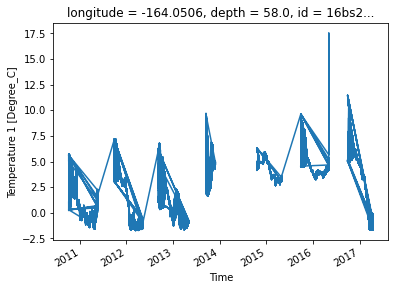

In [25]:
subxd.ocean_temperature_1.plot()

so - still need to figure out how to parse out the data from these dimensions but...
effectively, be wary of using opendap like tools on tabular data - https://groups.google.com/g/erddap/c/kyYF8wcNeME/m/Z5C4sKk2AwAJ

how about the other datasets? ncCFMA?

In [39]:
xadf = xa.load_dataset('/Users/bell/Downloads/foci_rehosted_e932_978b_9e7c_92b9_0f7b_bdd5.nc')

In [40]:
xadf

<xarray.Dataset>
Dimensions:                                                (obs: 34645, timeseries: 103)
Coordinates:
    longitude                                              (timeseries) float32 ...
    latitude                                               (timeseries) float32 ...
    depth                                                  (timeseries) float32 ...
    time                                                   (timeseries, obs) datetime64[ns] ...
Dimensions without coordinates: obs, timeseries
Data variables:
    id                                                     (timeseries) object ...
    lon360                                                 (timeseries) float32 ...
    ocean_velocity_u_eastward_true_north                   (timeseries, obs) float32 ...
    ocean_velocity_v_northward_true_north                  (timeseries, obs) float32 ...
    ocean_current_speed_component                          (timeseries, obs) float32 ...
    ocean_current_direction_component_true_north           (timeseries, obs) float32 ...
    ocean_temperature_1                                    (timeseries, obs) float32 ...
    ocean_depth                                            (timeseries, obs) float32 ...
    ocean_chlorophyll_a_concentration_factoryCal           (timeseries, obs) float32 ...
    ocean_chlorophyll_fluorescence_raw                     (timeseries, obs) float32 ...
    ocean_chlorophyll_fluorescence_raw_standard_deviation  (timeseries, obs) float32 ...
    ocean_conductivity_1                                   (timeseries, obs) float32 ...
    ocean_dissolved_oxygen_concentration_1_mMperkg         (timeseries, obs) float32 ...
    ocean_oxygen_saturation_1                              (timeseries, obs) float32 ...
    ocean_practical_salinity_1                             (timeseries, obs) float32 ...
    ocean_turbidity_FNU                                    (timeseries, obs) float32 ...
    photosynthetically_active_radiation                    (timeseries, obs) float32 ...
    photosynthetically_active_radiation_raw                (timeseries, obs) float32 ...
Attributes:
    cdm_data_type:                 TimeSeries
    cdm_timeseries_variables:      id, longitude, lon360, latitude, depth
    Conventions:                   CF-1.6, COARDS, ACDD-1.3
    creator_name:                  PMEL EcoFOCI
    creator_type:                  institution
    Easternmost_Easting:           -164.0506
    featureType:                   TimeSeries
    geospatial_lat_max:            56.8796
    geospatial_lat_min:            56.8633
    geospatial_lat_units:          degrees_north
    geospatial_lon_max:            -164.0506
    geospatial_lon_min:            -164.0663
    geospatial_lon_units:          degrees_east
    geospatial_vertical_max:       69.0
    geospatial_vertical_min:       9.0
    geospatial_vertical_positive:  down
    geospatial_vertical_units:     m
    history:                       FERRET V7.42 (optimized) 27-Aug-18FERRET V...
    id:                            EcoFOCI_Bering_Sea_timeseries_data_8571_f3...
    infoUrl:                       ???
    institution:                   PMEL EcoFOCI
    keywords:                      2010-2017, active, bering, calibration, ch...
    keywords_vocabulary:           GCMD Science Keywords
    license:                       The data may be used and redistributed for...
    Northernmost_Northing:         56.8796
    sourceUrl:                     (local files)
    Southernmost_Northing:         56.8633
    standard_name_vocabulary:      CF Standard Name Table v29
    subsetVariables:               id, longitude, lon360, latitude, depth
    summary:                       Pacific Marine Environmental Laboratory (P...
    time_coverage_end:             2017-04-16T11:20:00Z
    time_coverage_start:           2010-10-05T03:00:00Z
    title:                         PMEL EcoFOCI Bering Sea, 2010-2017
    Westernmost_Easting:           -164.0663

 ...]

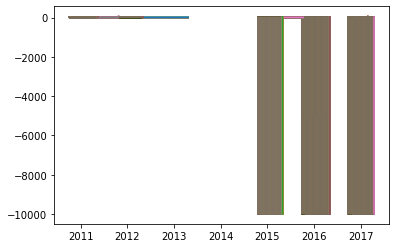

In [47]:
plt.plot(xadf.time,xadf.ocean_depth)